In [ ]:
import numpy as np
import dynamic_pricing as dp
from IPython.display import HTML
from scipy.stats import gamma
import matplotlib.pyplot as plt

### Div Dasani

# Single-Agent Dynamic Pricing with Reinforcement Learning

In [39]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Note: the code in this notebook has been hidden for easier reading.
To toggle this setting, click <a href="javascript:code_toggle()">here</a>.''')

### A. Motivation
The purpose of this research is to shed light on dynamic pricing approaches for economic agents, and contrast their profit maximization ability with static pricing approaches as dictated by standard microeconomic theory.

As a motivating example, consider the case of the television network provider (NBC, CBS, etc.). Such a business typically makes revenue through airing advertisements between programming. The television network therefore is selling a product (consumers' attention) to companies in exchange for revenue. However, it is unable to segment the individuals watching the channel based on specific characteristics, such as gender, age, etc. Therefore, supposing that a network has $N$ monthly viewers, only approximately $N/2$ of these viewers are female. So, when a company selling dresses wishes to advertise on the television network, the value it places on the product it is purchasing (consumer attention) is far less than its true value, as the company's advertisement will favorably affect purchasing behavior in, at most, only 50% of the population.

Contrast this with an online video streaming platform (YouTube, Vimeo, etc.). Such a platform not only serves content on an individualized basis, but also has access to user data, such as viewing interests, and possibly even demographical information. Because of the individualization of content delivery, such platforms can display different advertisements to different users, and thus can target users with advertisements that are more likely to increase engagement with the advertisement. Thus, such a platform can *dynamically price* its advertisements by charging different advertisers different costs to advertise depending on how closely the viewer aligns with desired characteristics for each advertiser.

This is only one example for the use of dynamic pricing, but this method of pricing goods can be used in a diverse variety of fields, such as in virtual gaming or salary negotiation.

This research displays the methods and advantages of dynamic pricing by generating consumer data and comparing the proft maximizing ability of static and dynamic pricing methods.

## B. Hyperparameters
These are the hyperparameters that can be adjusted to compliment different experiments. They will be referenced throughout the notebook.


*gen_probs*- vector in $\mathbb{R}^n$ where each element denotes the $p$ value of the Bernoulli distribution from which characteristic $x_{i,j}$ is drawn for $j\in(1,..,n)$
<br>
*weights*- vector in $\mathbb{R}^{n+1}$ where the first element is a constant and each subsequent element denotes the weight assigned to characteristic $x_{i,j}$ for $j\in(1,..,n)$
<br>
*sample_size*- the number of generated instances of $\vec{X_i}$
<br>
*train_ratio*- the ratio of sample instances to be used for algorithm training over the sample size
<br>
*rate*- the learning rate of the automatic controller
<br>
*max_it*- the automatic controller's maximum number of iterations of gradient descent
<br>
*c*- the variable cost of producing the good. Can be set to $0$ for revenue maximization

In [20]:
gen_probs = [0.5,0.6,0.3,0.4]
weights = np.array([1,40,10,30,19])
sample_size = 2500
train_ratio = 0.8
rate = 10**(-5)
max_it = 500
c = 0

## C. Sample Generation
In this research, a sample intended to represent a hypothetical consumer base is generated and the two pricing methods are implemented across this population to analyze performance differences.

Each consumer can be represented as a random vector $\vec{X_i} = (x_{i,1},...,x_{i,n}, p_i)$ where each of $x_{i,1},...,x_{i,n}$ represents a characteristic of individual $i$ (age, gender, income, etc.), and $p_i$ represents the value assigned to the good by consumer $i$. Because such information cannot be easily obtained, a sample of data is generated in this format. For each individual, a vector of length $n$ = 4 is randomly generated, where the value of $x_{i,j}$ for $j \in \{1,...,4\}$ is randomly generated via the Bernoulli distribution with probability *gen_probs*[$j$]. Once values have been generated for all $x_{i,j}$, the parameter $\alpha_{i}$ is calculated by multiplying $\vec{x_i} = (1, x_{i,1},...,x_{i,4})$ with the transpose of the weight vector *weights*. A $p_i$ is then randomly selected from a gamma distribution with shape parameter $\alpha_{i}$ and rate parameter $\sqrt {\alpha_{i}}$. This process is repeated for each $\vec{X_i}$ for $i\in\{1,...,$ *sample_size*$\}$. The data is generated like this for several reasons,
1. Randomly generating characteristical data allows the characteristics to remain arbitrary, maintaining generality
2. Multiplying characteristic values by weights allows one to modify the significance of the effect of each characteristics on consumer behavior
3. Drawing $p_i$ from a distribution defined by the characteristics of consumer $i$ allows for the existence of a correlation between these characteristics and the generated value, which mimics real consumer behavior, but still allows for stochasticity in the data.
4. $p_i$ was drawn from the gamma distribution because its probability density function plausibly mimics real consumer behavior while maintaining the desired support of $(0, \infty)$

In [21]:
sample, value = dp.generate_sample(sample_size, gen_probs, weights)

train_size = int(sample_size*train_ratio)
x_train = sample[:train_size].T
y_train = np.asarray(value)[:train_size]
x_test = sample[train_size:].T
y_test = np.asarray(value)[train_size:]

Hypothetical price distributions are shown below for $\alpha = 25$ and $\alpha = 50$.

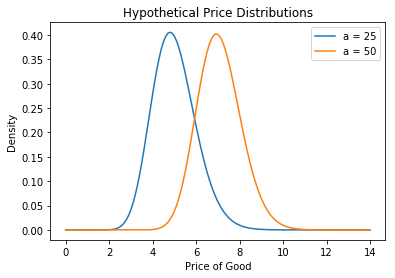

In [22]:
ubound = int(np.round(np.max(y_train),0)+1)
axis_10 = np.linspace(0,ubound,10*ubound+1)
plt.figure()
a1 = 25
a2 = 50
plt.plot(axis_10, gamma.pdf(axis_10,a1,scale=1/np.sqrt(a1)))
plt.plot(axis_10, gamma.pdf(axis_10,a2,scale=1/np.sqrt(a2)))
plt.xlabel('Price of Good')
plt.ylabel('Density')
plt.title('Hypothetical Price Distributions')
plt.legend(['a = {}'.format(a1),'a = {}'.format(a2)])
plt.show()

## D. Static Price Profit Maximization
We will compare the baseline method of static price maximization with the alternative approach of dynamic price maximization. Both methods will be provided a fraction, *train_ratio*, of the generated data to develop an optimal pricing mechanism. This will then be tested with the remaining fraction of data, where the algorithm will be given characteristical information ($x_{i,1},...,x_{i,4}$) but not valuation information ($p_i$) for each consumer $i$, and will be tasked with suggesting a price to charge each consumer to maximize its revenue.

Illustrated below is the population demand curve which is generated from the training data ('Experimental Curve'). A logistic demand curve ('Theoretical Curve') is also drawn. The logistic demand function is given by,
<br>
<center>$q_T(p) = (1+e^{a*(p-p_0)})^{-1}$ </center>
<br>
where $p_0$ denotes the inflection point of demand and $a > 0$ measures price sensitivity. We generate our logistic demand curve  with parameters $a = 0.65$ and $p_0 = \bar{p} = \frac{1}{train\_size} \sum_{i=1}^{train\_size} p_i$ where *train_size* $=$ $floor($*sample_size* $*$ *train_ratio*$)$

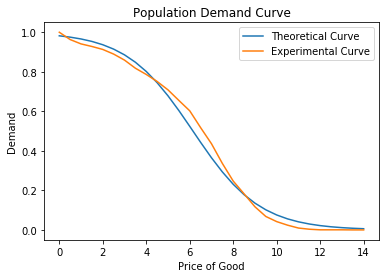

In [23]:
axis_2 = np.linspace(0,ubound,2*ubound+1)
plt.figure()
plt.plot(axis_2, dp.logistic_demand(0.65,np.mean(y_train),axis_2))
plt.plot(axis_2,dp.demand_curve(axis_2, y_train))
plt.xlabel('Price of Good')
plt.ylabel('Demand')
plt.title('Population Demand Curve')
plt.legend(['Theoretical Curve','Experimental Curve'])
plt.show()

We now train the static pricing algorithm as governed by microeconomic theory. That is, we select the static price, $p^*$, that maximizes,
<center> $\pi(p) = (p-c)*q_d(p)$ </center>
<br>
where $c$ is given by the hyperparameter *c*, the variable cost of producing the good. Throughout this document, profit is given as average profit per person (APP), and is calculated by summing the profits across the population and dividing by the total population of consumers. A plot of profit vs. price for static price profit maximization is given below. According to the figure, $p^* = 6.0$, where APP is maximized at $3.68$

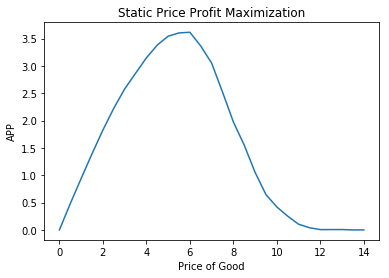

Optimized Static APP: 3.68
Optimized Price: 6.0


In [24]:
app_s_train = dp.APP_s(axis_2, y_train, c)
index = np.argmax(app_s_train)
app_s_test = dp.APP_s(axis_2, y_test, c)
app_s_star = app_s_test[index]

plt.figure()
plt.plot(axis_2, app_s_train)
plt.xlabel('Price of Good')
plt.ylabel('APP')
plt.title('Static Price Profit Maximization')
plt.show()
print('Optimized Static APP: {:.2f}'.format(app_s_star))
print('Optimized Price:', axis_2[index])

## E. Dynamic Price Profit Maximization
Now, we will train an automatic controller to predict $p_i$, the value each person $i$ assigns the good, based on her characteristics $x_{i,1},...,x_{i,4}$. Note that we do not give the algorithm any information on how $p_i$ is drawn.

The automatic controller employs gradient descent to minimize a cost function. In this case, the cost function we will employ is given by,
<center>$L(\vec{w}) = \sum_{i=1}^{train\_size} (\vec{w}^T*\vec{x}_i - p_i)^2$</center>
<br>
We attempt to find the weight vector $\vec{w}^*$ which, when multiplied by any characteristic vector $\vec{x}_i$, minimizes the average difference between our predicted value for consumer $i$ ($\hat{p}_i = \vec{w}^T*\vec{x}_i$) and the true value $p_i$. This is the intuition behind the cost function.


We train the automatic controller with cost function $L$, and learning rate *rate* for *max_it* iterations. The cost history plot is depicted below. 

In [25]:
x_train = x_train[np.newaxis, :]
y_train = y_train[np.newaxis, :]
x_test = x_test[np.newaxis, :]
y_test = y_test[np.newaxis, :]
wh, ch = dp.gradient_descent(dp.least_squares,rate,max_it,np.random.rand(5),x_train,y_train)

index = np.argmin(ch)
w_star = wh[index]
cost_train = ch[index]
cost_test = dp.least_squares(w_star,x_test,y_test)/x_test.shape[2]
app_d_1 = dp.APP_d(w_star,x_test,y_test,c,1)

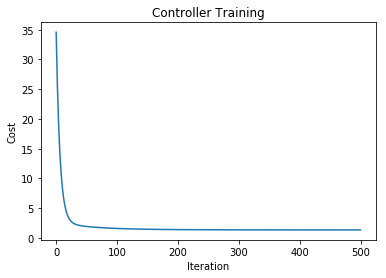

Optimized Weights:  [ 2.4  3.5  1.   2.5  1.8]
Optimized Cost: 1.36
Test Cost: 1.36
Dynamic APP: 3.24


In [26]:
axis = range(max_it+1)
plt.figure()
plt.plot(axis,ch)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Controller Training')
plt.show()


print('Optimized Weights: ', np.round(w_star,1))
print('Optimized Cost: {:.2f}'.format(cost_train))
print('Test Cost: {:.2f}'.format(cost_test))
print('Dynamic APP: {:.2f}'.format(app_d_1))

Once the automatic controller completed its training, it output the value of $\vec{w}^*$, along with the optimized training cost and the test cost, which is the cost value attained when $\vec{w}^*$ was used to predict values for the test set which it had not been trained on. The fact that these two values are approximately identical implies that we did not overfit or underfit our model. However, the APP for this dynamic pricing system is $3.24$, which is less than the static pricing APP value of $3.68$.


Though it may seem counterintutitive at first, this is actually expected. The cost function $L$ works to minimize the *absolute difference* between $\hat{p}_i$ and $p_i$, which means it prefers $\vec{w}_1$ which generates $\hat{p}_{i,1} = p_i + \epsilon$ to $\vec{w}_2$ which generates $\hat{p}_{i,2} = p_i - 2*\epsilon$ for an arbitrarily small $\epsilon>0$. However, the consumer will not purchase the good if offered it at price $\hat{p}_{i,1}$, and will purchase the good if offered it at $\hat{p}_{i,2}$. Thus, this high likeliness for slight overestimation is heavily decreasing the APP of the dynamic pricing system.


To counteract this effect, we employ a discounting parameter $d\in(0,1]$, that dampens the offered price from $\hat{p}_i$ to $d*\hat{p}_i$. This way, even if $\vec{w}^*$ slightly overestimates $p_i$, the dampening will significantly increase the likelihood that $d*\hat{p}_i\leq p_i$ while minimizing $p_i - d*\hat{p}_i$. To select the optimal value of $d$, we plot several on the interval of $[0.7,1]$ and compare them against the APP. We then select the discount parameter $d^*$ that yields the highest APP in our training data, and employ it in our test data to recalculate our dynamic pricing APP. These results are shown below.

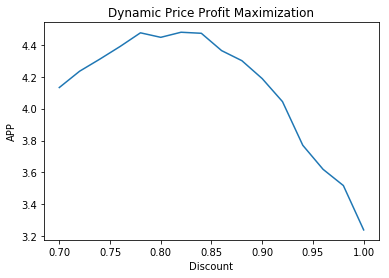

Optimized Discount: 0.82
Test Dynamic APP: 4.42


In [36]:
axis_d = np.linspace(0.7,1,16)
app_d = []
for d in axis_d:
    app_d.append(dp.APP_d(w_star,x_test,y_test,c,d))

d_star = axis_d[np.argmax(app_d)]
app_d_star = dp.APP_d(w_star,x_train,y_train,c,d_star)

plt.figure()
plt.plot(axis_d,app_d)
plt.xlabel('Discount')
plt.ylabel('APP')
plt.title('Dynamic Price Profit Maximization')
plt.show()
print('Optimized Discount: {:.2f}'.format(d_star))
print('Test Dynamic APP: {:.2f}'.format(app_d_star))

## F. Conclusion

In [38]:
print('Dynamic APPU (Test-based): {:.2f}'.format(app_d_star))
print('Static APPU (Test-based): {:.2f}'.format(app_s_star))
print('Percentage in Profit Increase: {:.2%}'.format((app_d_star-app_s_star)/app_s_star)) 

Dynamic APPU (Test-based): 4.42
Static APPU (Test-based): 3.68
Percentage in Profit Increase: 19.89%


As depicted by the results above, employing a dynamic pricing strategy as shown above on the data increased profits by nearly $20\%$. Though this number means little given the arbitrary values in the data, the significant difference between the static pricing APP and the dynamic pricing APP demonstrates a solid case for employing dynamic pricing methods where applicable, and the methods outlined in this research indicate how to accomplish this task.